## Anomaly Detection Lesson  
## Continuous variable probabilistic methods for identifying outliers

16 February 2023

異常和外露層的比較。

_Statistical Methods_  
Number of standard deviations from the mean -- how many and why, for this observation ?   
Tine series data -- deviation from historic moving average.  
Mean, median, mode.  
These can be difficult with noisy data, as it is already not very consistent.  

_Clustering_  
K-means : abnormally small clusters isolated from rest of data may be anomalies.   
DBSCAN : density-based clustering that highlights datapoints not part of the majority of the clusters.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from pydataset import data

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = "https://gist.githubusercontent.com/ryanorsinger/6218f5731f3df7cb4771ff3879fdeaa3/raw/88cb6bed276e2236c33df011bd753b6c73832c30/quartet.csv"

In [3]:
df = pd.read_csv(url)

df.sample(3)

,id,dataset,x,y
27,27,III,14.0,8.84
8,8,I,12.0,10.84
36,36,IV,8.0,8.84


In [10]:
df.groupby('dataset').describe()

id                                                   x       ...  \
        count  mean       std   min   25%   50%   75%   max count mean  ...   
dataset                                                                 ...   
I        11.0   5.0  3.316625   0.0   2.5   5.0   7.5  10.0  11.0  9.0  ...   
II       11.0  16.0  3.316625  11.0  13.5  16.0  18.5  21.0  11.0  9.0  ...   
III      11.0  27.0  3.316625  22.0  24.5  27.0  29.5  32.0  11.0  9.0  ...   
IV       11.0  38.0  3.316625  33.0  35.5  38.0  40.5  43.0  11.0  9.0  ...   

                        y                                                      
          75%   max count      mean       std   min    25%   50%   75%    max  
dataset                                                                        
I        11.5  14.0  11.0  7.500909  2.031568  4.26  6.315  7.58  8.57  10.84  
II       11.5  14.0  11.0  7.500909  2.031657  3.10  6.695  8.14  8.95   9.26  
III      11.5  14.0  11.0  7.500000  2.030424  5.39  6.250  7.11  7.98  12.74  
IV        8.0  19.0  11.0  7.500909  2.030579  5.25  6.170  7.04  8.19  12.50  

[4 rows x 24 columns]

In [5]:
mycols = list(itertools.product(['x','y'], ['50%', 'mean', 'max', 'std']))

In [6]:
# looking at specific columns in mycols

df.groupby('dataset').describe()[mycols]

x                          y                           
         50% mean   max       std   50%      mean    max       std
dataset                                                           
I        9.0  9.0  14.0  3.316625  7.58  7.500909  10.84  2.031568
II       9.0  9.0  14.0  3.316625  8.14  7.500909   9.26  2.031657
III      9.0  9.0  14.0  3.316625  7.11  7.500000  12.74  2.030424
IV       8.0  9.0  19.0  3.316625  7.04  7.500909  12.50  2.030579

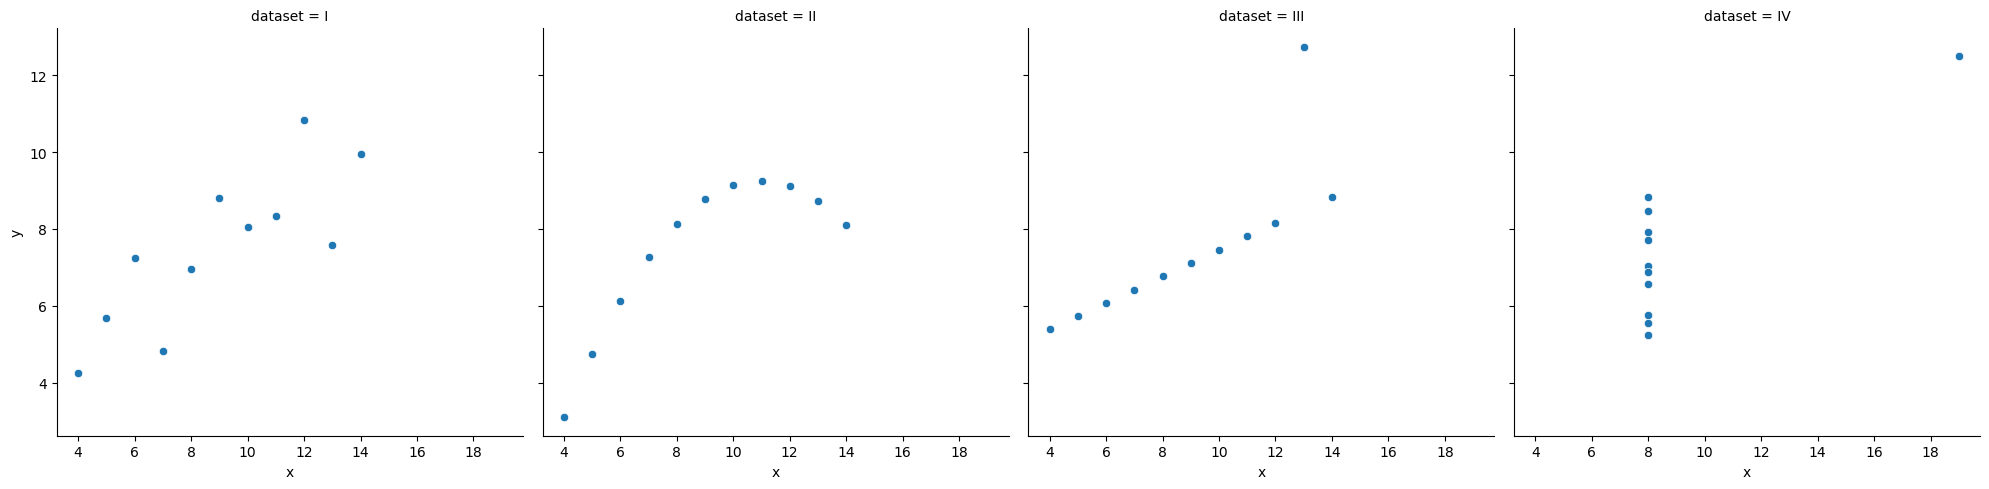

In [13]:
# plotting the dataset

sns.relplot(x = 'x', y = 'y', col = 'dataset', data = df)

68 - 95 - 99.7 Rule (2.35pc - 13.5pc - 34pc)  

Mistakes :   
    Saying that a dp is an anomaly / falls too far outside of the mean and should be dropped, without exploring.   
    Assuming normal distribution. The 68 - 95 - 99.7 rule assumes normal distribution.  
 

Scores for identifying outliers :  
    Z-score.  
    ```np.random.normal``` : put in mean, std dev, sample size  
    https://ds.codeup.com/anomaly-detection/continuous-probabilistic-methods/#the-empirical-rule-aka-three-sigma-rule-aka-6895997-rule  
    If not normal, use IQR>  

In [18]:
# create an array of random numbers w normal distro

x = np.random.normal(50, 40, size = 1000)
x

array([ 8.49231712e+01,  2.68761240e+01,  1.71976788e+02, -8.36739604e+00,
        8.87482277e+01,  2.73620815e+01,  1.09582411e+02, -3.32009046e+01,
        7.51938565e+01,  1.13641681e+02,  2.60126002e+01, -9.34850929e+00,
       -6.86909336e+00,  8.72999953e+01,  6.33517261e+01,  3.00100933e-01,
        1.30919785e+01,  4.81932388e+01,  1.86450172e+01,  8.00730676e+01,
        1.21748311e+02,  2.78104442e+01,  7.03480265e+01,  2.64510455e+01,
        6.24883926e+01,  4.57258499e+01, -1.11729166e+01,  9.80488819e+00,
        2.11082258e+01,  2.99268183e+01,  5.23784334e+00, -1.74409031e+00,
       -4.24016624e+01,  9.15474124e+01,  6.25613184e+01,  1.46987483e+02,
       -6.13997094e+00,  1.43089888e+01,  4.35991818e+01,  4.64857622e+01,
        4.58512570e+01,  2.92679817e+01,  8.25521083e+01,  8.80517244e+01,
        8.90131123e+01, -1.48058370e+01,  2.03398157e+01,  2.57813448e+01,
        1.28153638e+02,  6.05700351e+01,  8.63640420e+01,  3.41308143e+01,
        1.41344195e+01,  

In [21]:
# claculate z-score for each item in teh array

zscores = pd.Series((x - x.mean())) / x.std()
zscores

0      0.852674
1     -0.566970
2      2.981725
3     -1.428913
4      0.946222
         ...   
995   -1.122871
996    0.386460
997   -0.428820
998    0.375995
999   -0.398559
Length: 1000, dtype: float64

In [23]:
# find all observations outside of 2 std deviations (greater than inside the 95th percentile)

x[zscores.abs() >= 2]

array([171.97678751, -33.20090464, -42.40166241, 146.98748265,
       -60.53406597, -58.09850518, 148.47201338, 148.67023052,
       132.10442313, 157.54897955, -33.84446417, -41.95486845,
       -48.38212524, 143.96127897, 164.13292477, 133.43063564,
       -38.83626027, 138.67213779, -48.36120559, -57.86118577,
       -41.86409027, -40.32156939, 134.76164073, -45.06227212,
       157.08880037, 151.09355414, 181.77606712, 142.35443801,
       151.4442902 , 136.2144282 , 139.2906418 , -32.11991233,
       137.80976118, -47.82791703, 139.76346798, 179.20037686,
       160.24867317, -35.7747881 , 143.85896321, 148.0688672 ,
       -67.11916156, 145.94498923, -34.11492507])

In [24]:
# howm many observations is this

len(x[zscores.abs() >= 2])

# 43 numbers total that fall outside of the 95th percentile

43

In [25]:
# find all obs w 3 std dev or more

x[zscores.abs() >= 3]

array([181.77606712, 179.20037686])

### Swiss dataset

In [26]:
# import

suisse = data('swiss')

In [27]:
suisse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


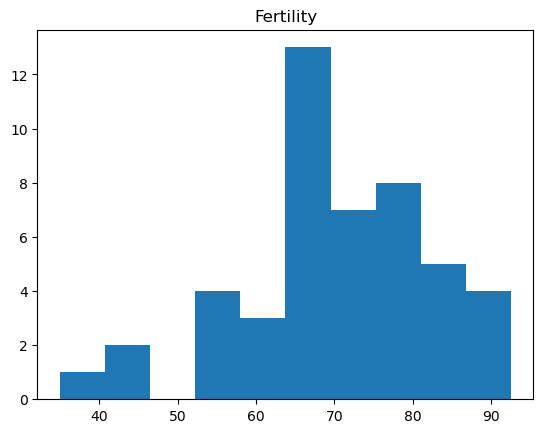

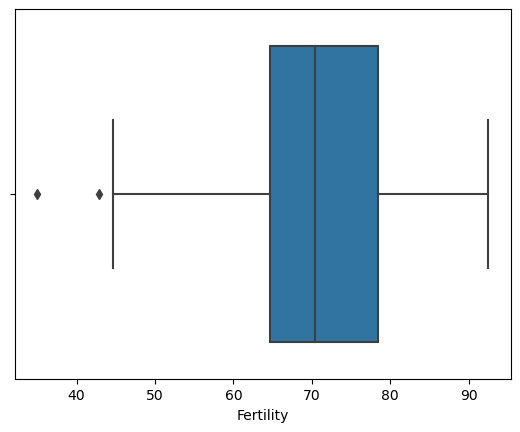

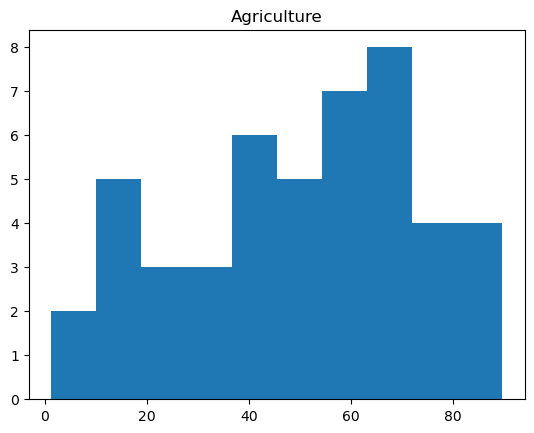

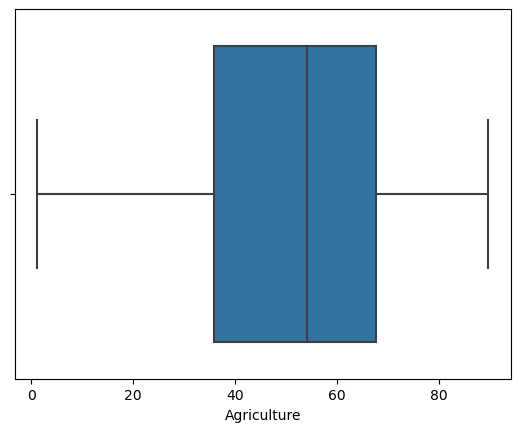

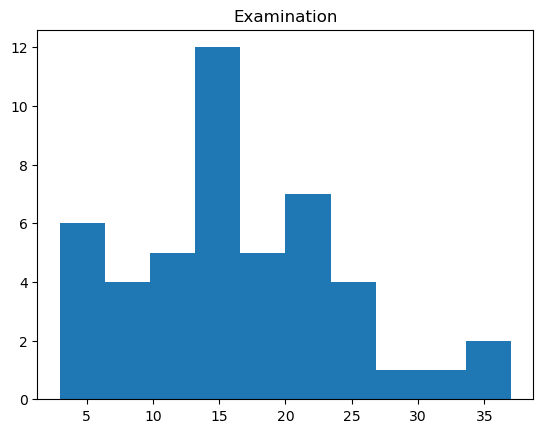

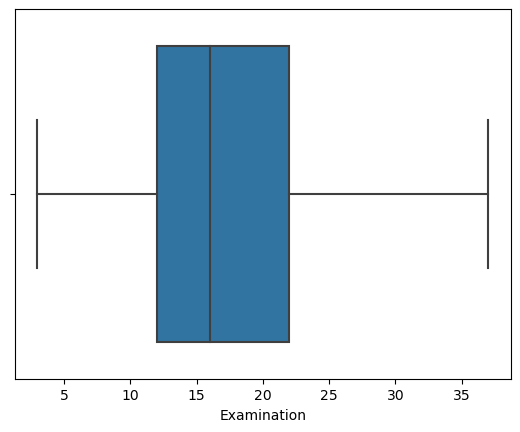

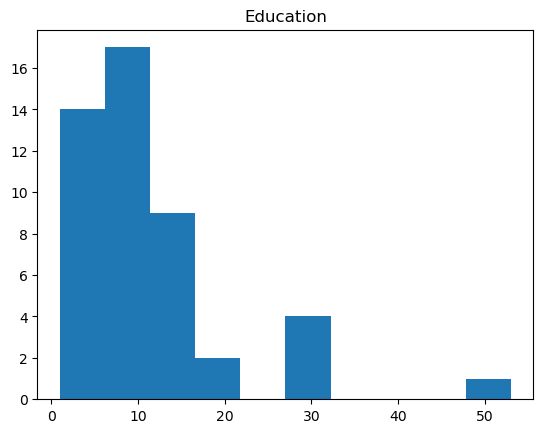

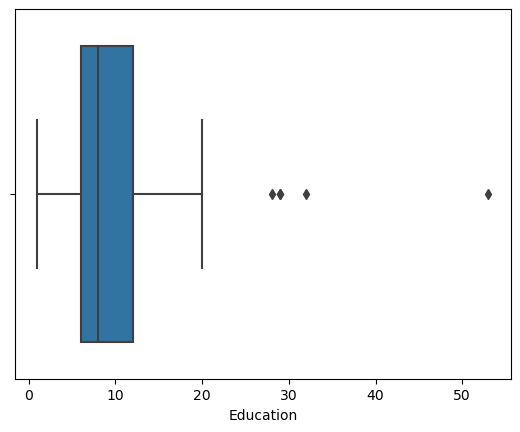

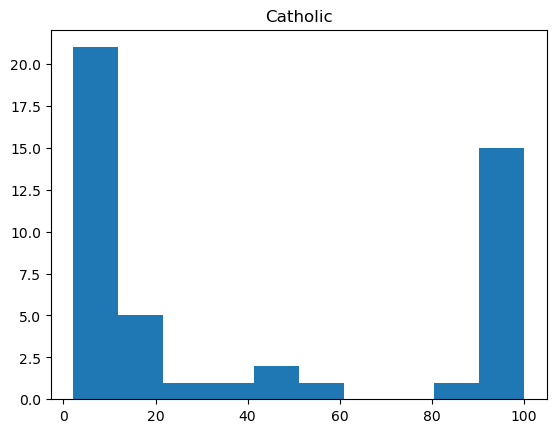

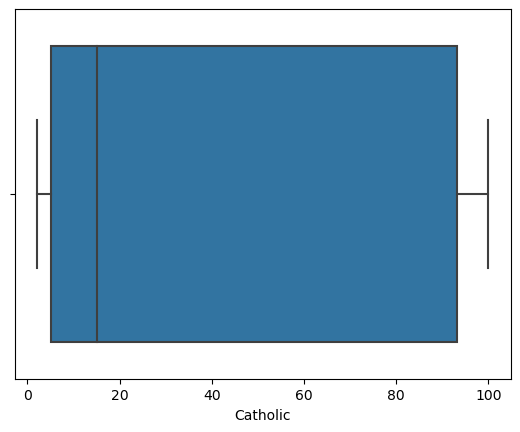

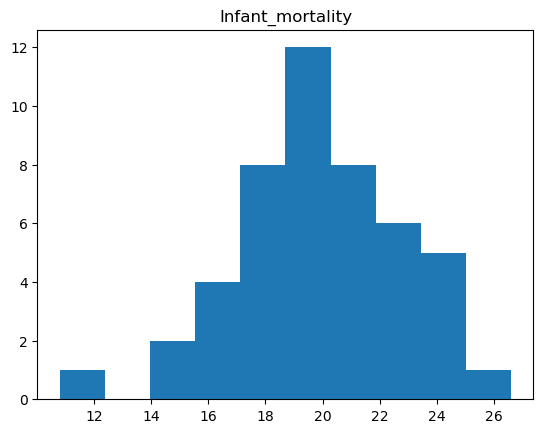

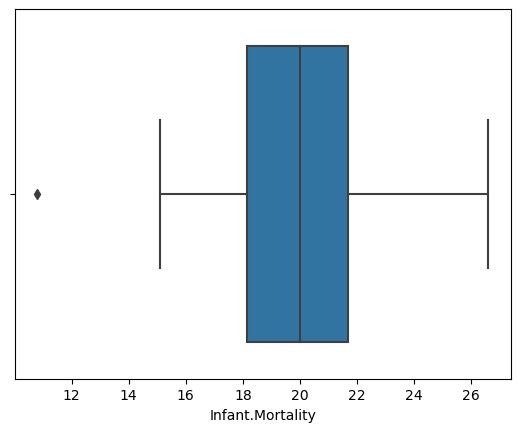

In [32]:
# 

cols = suisse.columns.to_list()

for col in cols :
    plt.hist(suisse[col])
    plt.title(col.replace('.','_').capitalize())
    plt.show()
    sns.boxplot(data = suisse, x = col)
    plt.show()

In [34]:
suisse.head(3)

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
